# 필요한 library import

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 불러오기

In [32]:
match_data = pd.read_csv('data/데이터 분석가_과제_Type A/match_data.csv')

In [33]:
match_data

,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,tier,itemid,matchresult,matchscore,isDrop,isEscape
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,1812,G69102,1,0,0.428571,7,gold,1364,0,25,1,0
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,1868,NaN,1,0,0.333333,9,gold,1178,0,35,0,0
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,1809,G5900,0,2,0.200000,162,platinum,1385,0,39,0,0
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,1631,G424,2,0,0.300000,11,bronze,1338,0,0,1,0
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,1973,NaN,0,3,0.500000,412,platinum,1277,1,41,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410379,2022-06-27 01:47:35,m03c40017117a01f2,621010036,1,1990,G45703,0,5,0.500000,191,platinum,1337,1,44,0,0
410380,2022-06-27 01:47:35,m03c40017117a01f2,1711756742,2,2050,G185081,0,1,0.500000,1201,platinum,1398,0,45,0,0
410381,2022-06-27 01:47:35,m03c40017117a01f2,1460484825,2,2055,NaN,0,1,0.500000,139,bronze,1398,0,49,0,0
410382,2022-06-27 01:47:35,m03c40017117a01f2,218329344,2,1966,G28051,0,2,0.300000,389,platinum,1411,0,48,0,0


# 데이터 전처리

## 누락된 값 확인

In [34]:
missing_values = match_data.isnull().sum()

In [35]:
missing_values

createdatekst         0
matchid               0
accountid             0
teamid                0
mmr                   0
guildid          232957
winstreak             0
losestreak            0
recentwinprob         0
accumatches           0
tier                  0
itemid                0
matchresult           0
matchscore            0
isDrop                0
isEscape              0
dtype: int64

In [36]:
match_data['guildid'].value_counts()

guildid
G179296    1814
G844       1641
G2350      1281
G23565     1143
G61125     1082
           ... 
G172660       1
G189943       1
G34473        1
G21963        1
G13588        1
Name: count, Length: 3365, dtype: int64

### 'guildid'애 대해 길드별로 성능 지표를 산출

In [41]:
# 먼저 'guildid'에서 NaN 값을 처리합니다. 이 예에서는 'NoGuild'로 대체합니다.
match_data['guildid'].fillna('NoGuild', inplace=True)

# 티어를 숫자로 변환합니다.
tier_mapping = {'unranked': 0, 'bronze': 1, 'silver': 2, 'gold': 3, 'platinum': 4, 'diamond': 5, 'master': 6}
match_data['tier_numeric'] = match_data['tier'].map(tier_mapping)

# 길드별로 데이터를 그룹화하고 그룹별로 평균을 계산합니다.
guild_avg = match_data.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].mean()

# 새로운 컬럼 이름을 생성합니다.
new_columns = {col: f'{col}_guild_avg' for col in guild_avg.columns}
guild_avg.rename(columns=new_columns, inplace=True)

# 원본 데이터셋에 계산된 길드 성능 지표를 병합합니다.
match_data = pd.merge(match_data, guild_avg, on='guildid', how='left')

In [42]:
match_data

,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,...,matchresult,matchscore,isDrop,isEscape,tier_numeric,mmr_guild_avg,winstreak_guild_avg,recentwinprob_guild_avg,accumatches_guild_avg,tier_numeric_guild_avg
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,1812,G69102,1,0,0.428571,7,...,0,25,1,0,3,1887.000000,0.333333,0.459656,4.444444,3.000000
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,1868,NoGuild,1,0,0.333333,9,...,0,35,0,0,3,1994.394511,0.991028,0.490311,393.967106,3.740939
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,1809,G5900,0,2,0.200000,162,...,0,39,0,0,4,1918.224719,0.617978,0.416854,149.646067,4.000000
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,1631,G424,2,0,0.300000,11,...,0,0,1,0,1,1680.200000,0.500000,0.311690,79.940000,1.860000
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,1973,NoGuild,0,3,0.500000,412,...,1,41,0,0,4,1994.394511,0.991028,0.490311,393.967106,3.740939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410379,2022-06-27 01:47:35,m03c40017117a01f2,621010036,1,1990,G45703,0,5,0.500000,191,...,1,44,0,0,4,1920.273292,1.018634,0.478261,208.782609,4.000000
410380,2022-06-27 01:47:35,m03c40017117a01f2,1711756742,2,2050,G185081,0,1,0.500000,1201,...,0,45,0,0,4,2017.380952,0.571429,0.404762,1204.000000,4.000000
410381,2022-06-27 01:47:35,m03c40017117a01f2,1460484825,2,2055,NoGuild,0,1,0.500000,139,...,0,49,0,0,1,1994.394511,0.991028,0.490311,393.967106,3.740939
410382,2022-06-27 01:47:35,m03c40017117a01f2,218329344,2,1966,G28051,0,2,0.300000,389,...,0,48,0,0,4,2012.675000,0.850000,0.480000,400.500000,4.000000


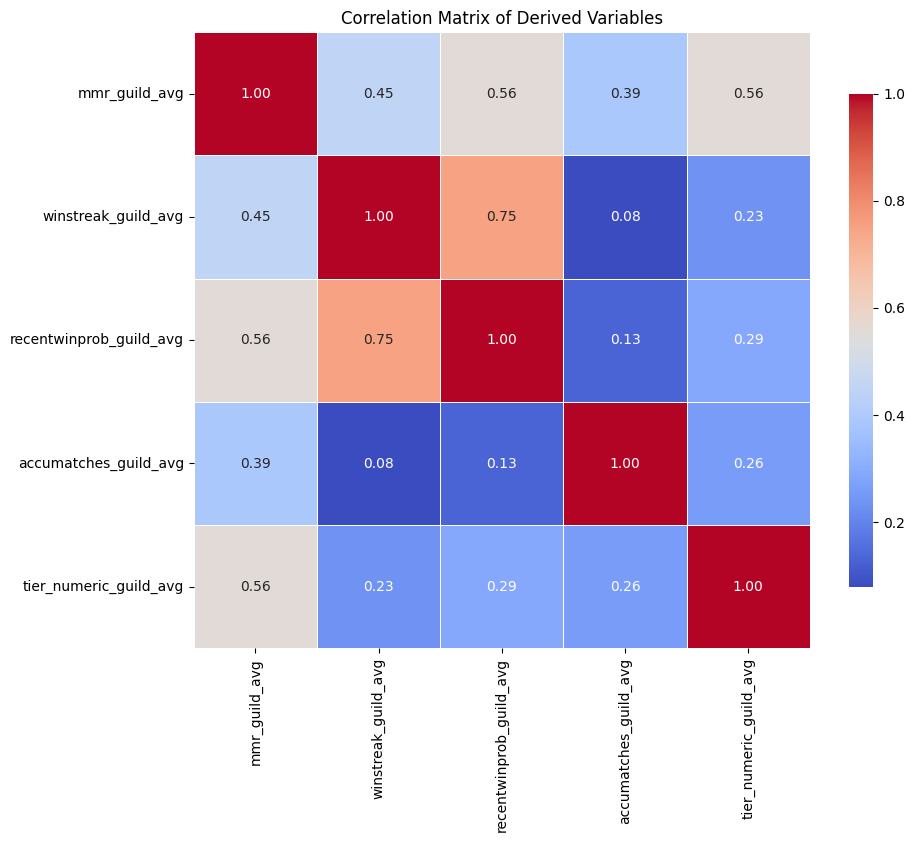

In [43]:
correlation_matrix = match_data[[
    'mmr_guild_avg', 'winstreak_guild_avg', 
    'recentwinprob_guild_avg', 'accumatches_guild_avg', 
    'tier_numeric_guild_avg'
]].corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink':.8},
    linewidths=.5
)
plt.title('Correlation Matrix of Derived Variables')
plt.show()

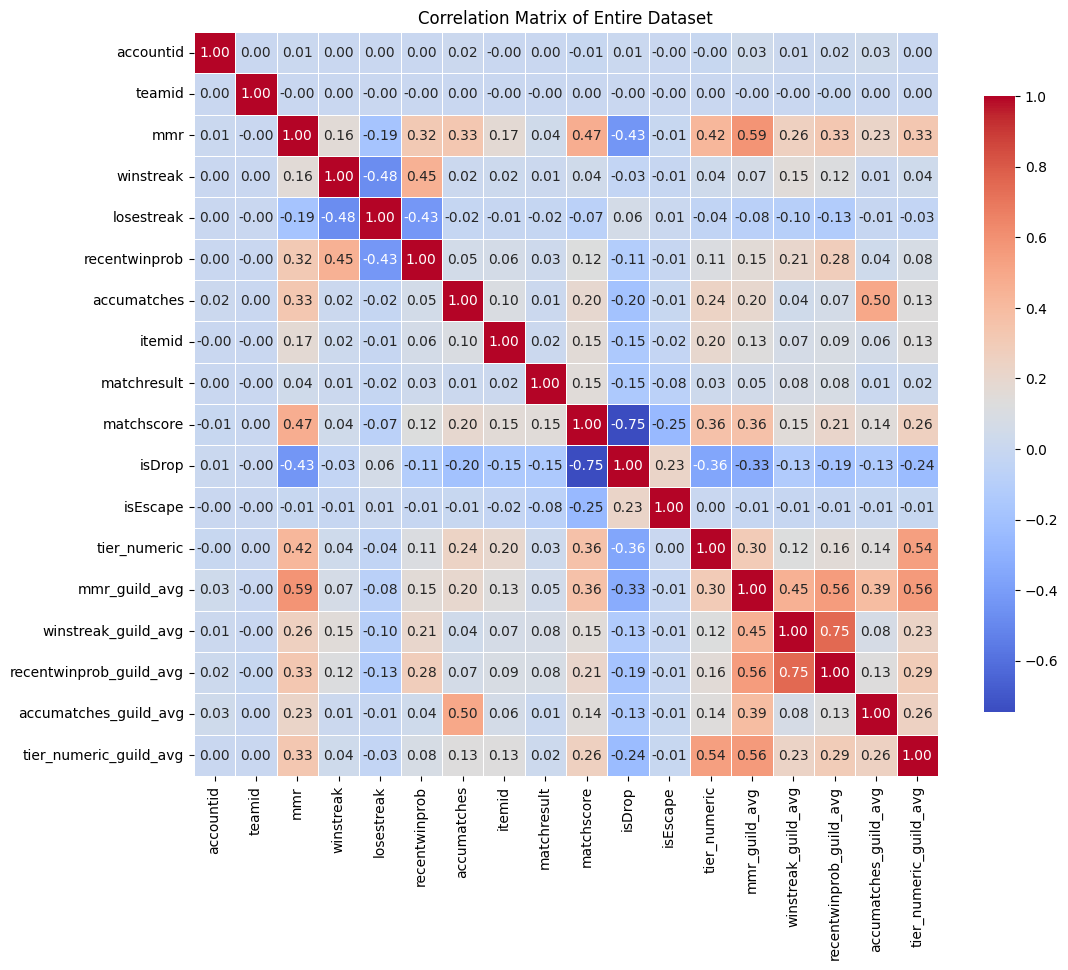

In [47]:
# 숫자 데이터만 선택
numeric_data = match_data.select_dtypes(include=['number'])

# 상관관계 행렬 계산
correlation_matrix_all_data = numeric_data.corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix_all_data,
    annot=True,  # annot=True로 설정하면 모든 셀에 숫자가 표시되지만, 데이터가 많을 경우 가독성이 떨어질 수 있습니다.
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink':.8},
    linewidths=.5
)
plt.title('Correlation Matrix of Entire Dataset')
plt.show()